#Paquetes necesarios

In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la corespondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.



In [6]:

global total_value
total_value = 0
global scale
scale = None
global mask
mask = None

def load_image(filename):
    img = cv2.imread(filename)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.resize(img, (0, 0), fx=0.6, fy=0.6)
    return img, img_hsv

def detect_circles(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Smooth the image (remove high frequencies)
    pimg = cv2.medianBlur(gray, 7)
    # Detect circles
    circ = cv2.HoughCircles(
        pimg,
        cv2.HOUGH_GRADIENT,  # Detection method
        1,
        30,  # Minimum distance between circles
        param1=190,  # Gradient value
        param2=30,  # Accumulator threshold
        minRadius=15,  # Minimum radius
        maxRadius=90  # Maximum radius
    )

    return circ[0] if circ is not None else None

def draw_circles(img, circ):
    if circ is not None:
        for x_coor, y_coor, det_radio in circ:
            cv2.circle(img, (int(x_coor), int(y_coor)), int(det_radio), (0, 255, 0), 2)
    else:
        print("No circles detected.")
        exit()

def setup_window(img, circ, img_hsv):
    cv2.namedWindow('image')
    cv2.setMouseCallback('image', lambda event, x, y, flags, params: onclick(event, x, y, flags, circ, img_hsv))

    while True:
        cv2.imshow('image', img)
        if cv2.waitKey(20) & 0xFF == 27:
            break

def onclick(event, x, y, flags, circ, img_hsv):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Clicked at: ({x}, {y})")
        name, value = identify_coin(x, y, circ, img_hsv)
        if name:
            cv2.putText(img, name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

def identify_coin(x, y, circ, img_hsv):
    global total_value
    global scale

    if circ is None:
        print("No coins detected.")
        return None, 0

    for (cx, cy, radius) in circ:
        if is_click_inside_coin(x, y, cx, cy, radius):
            
            if scale is None:
                # Set the scale using the detected coin and calculate the total value
                set_scale_using_closest_coin(radius, circ, img_hsv)

            # Get the average color within the circle
            mean_color_hsv = detect_color_in_circle(img_hsv, cx, cy, radius)
            print(f"Average color in HSV: {mean_color_hsv}")

            # Classify the coin based on radius and color
            coin_value, coin_name = get_coin_value_and_color(radius, mean_color_hsv)
            print(f"Identified coin of {coin_name} at ({cx}, {cy}) with radius {radius}")

            return coin_name, coin_value

    print("No coin identified at the clicked position")
    return None, 0

def detect_color_in_circle(img_hsv, x_coor, y_coor, radius):
    reduced_radius = int(radius * 1.5)  # Adjust the percentage if necessary

    # Create a mask for the coin (circular region)
    mask = np.zeros(img_hsv.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (x_coor, y_coor), reduced_radius, 255, -1)

    # Apply Gaussian blur to smooth the HSV image
    blurred_img_hsv = cv2.GaussianBlur(img_hsv, (5, 5), 0)

    # Filter valid pixels
    masked_pixels = cv2.bitwise_and(blurred_img_hsv, blurred_img_hsv, mask=mask)
    non_zero_mask = mask.astype(bool)
    
    # Extract only pixels where the mask is valid
    hsv_values = masked_pixels[non_zero_mask]
    
    if hsv_values.size == 0:
        return (0, 0, 0)  # Return black if there are no valid pixels

    # Filter pixels based on saturation and brightness
    saturation_threshold = 30
    brightness_threshold = 30
    
    filtered_hsv = hsv_values[(hsv_values[:, 1] > saturation_threshold) & 
                              (hsv_values[:, 2] > brightness_threshold)]
    
    if filtered_hsv.size == 0:
        return (0, 0, 0)  # Return black if there are no valid pixels

    # Calculate the average color of the filtered pixels
    mean_color_filtered = np.mean(filtered_hsv, axis=0)

    return mean_color_filtered

def is_click_inside_coin(x, y, cx, cy, r):
    return (cx - x) ** 2 + (cy - y) ** 2 <= r ** 2

def set_scale_using_closest_coin(r, circ, img_hsv):
    global scale, total_value
    
    # Set the scale using the radius of the 1 euro coin
    scale = 23.25 / (r*2)
    print(f"Scale set to {scale:.2f} pixels per mm")

    # Now that the scale is set, calculate the total value of all detected coins
    total_value = 0
    for (cx, cy, radius) in circ:
        mean_color_hsv = detect_color_in_circle(img_hsv, cx, cy, radius)
        coin_value, coin_name = get_coin_value_and_color(radius, mean_color_hsv)
        total_value += coin_value

    print(f"Total value of all coins: {total_value:.2f} euros")
    return scale

def get_coin_value_and_color(radius, color_hsv):
    global coin_values
    radius_mm = radius * scale
    
    # Coin classification based on radius and color
    copper_hue_range = (0, 30)
    gold_hue_range = (15, 70)
    euro_hue_range = (0, 20)

    actual_value = 0
    actual_name = "unknown"
    radio = 0
    
    for diameter, (value, name) in coin_values.items():
        if abs(radius_mm - diameter / 2) < 0.5:
            hue = color_hsv[0]
            if name in ["1 cents", "2 cents", "5 cents"] and copper_hue_range[0] <= hue <= copper_hue_range[1]:
                if abs(radius_mm - diameter / 2) < abs(radius_mm - radio):
                    radio = diameter / 2
                    actual_name = name
                    actual_value = value
            elif name in ["1 euro", "2 euros"] and euro_hue_range[0] <= hue <= euro_hue_range[1]:
                if abs(radius_mm - diameter / 2) < abs(radius_mm - radio):
                    radio = diameter / 2
                    actual_name = name
                    actual_value = value
            elif name in ["10 cents", "20 cents", "50 cents"] and gold_hue_range[0] <= hue <= gold_hue_range[1]:
                if abs(radius_mm - diameter / 2) < abs(radius_mm - radio):
                    radio = diameter / 2
                    actual_name = name
                    actual_value = value

    return actual_value, actual_name

if __name__ == "__main__":

    # Coin values in mm
    coin_values = {
        16.25: (0.01, "1 cents"),
        18.75: (0.02, "2 cents"),
        19.75: (0.1, "10 cents"),
        21.25: (0.05, "5 cents"),
        22.25: (0.2, "20 cents"),
        23.25: (1.0, "1 euro"),
        24.35: (0.5, "50 cents"),
        25.75: (2.0, "2 euros"),
    }

    # Load image
    img, img_hsv = load_image("Monedas.jpg")

    # Detect circles (coins)
    circ = detect_circles(img)

    if circ is not None:
        circ = np.round(circ).astype("int")
        draw_circles(img, circ)
        setup_window(img, circ, img_hsv)
    else:
        print("No circles detected.")

    cv2.destroyAllWindows()

    print(f"Total value of all coins: {total_value:.2f} euros")



Clicked at: (84, 195)
Scale set to 0.21 pixels per mm
Total value of all coins: 3.88 euros
Average color in HSV: [ 16.76121401  80.78654318 202.27995983]
Identified coin of 1 euro at (82, 206) with radius 55
Clicked at: (117, 100)
Average color in HSV: [ 16.32103615  83.51028175 205.20360935]
Identified coin of 2 euros at (78, 68) with radius 62
Clicked at: (84, 364)
Average color in HSV: [ 34.73027562  65.83294761 170.66694719]
Identified coin of 50 cents at (84, 348) with radius 59
Clicked at: (81, 463)
Average color in HSV: [ 20.34528896 126.45615021 179.77344277]
Identified coin of 20 cents at (86, 484) with radius 54
Clicked at: (208, 480)
Average color in HSV: [ 20.07014682 137.69779772 191.24265905]
Identified coin of 1 cents at (220, 486) with radius 40
Clicked at: (224, 320)
Average color in HSV: [ 25.68295995  67.99456891 174.80380177]
Identified coin of 2 cents at (220, 352) with radius 45
Clicked at: (228, 225)
Average color in HSV: [ 15.8776435   51.44360524 191.30866062]


TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

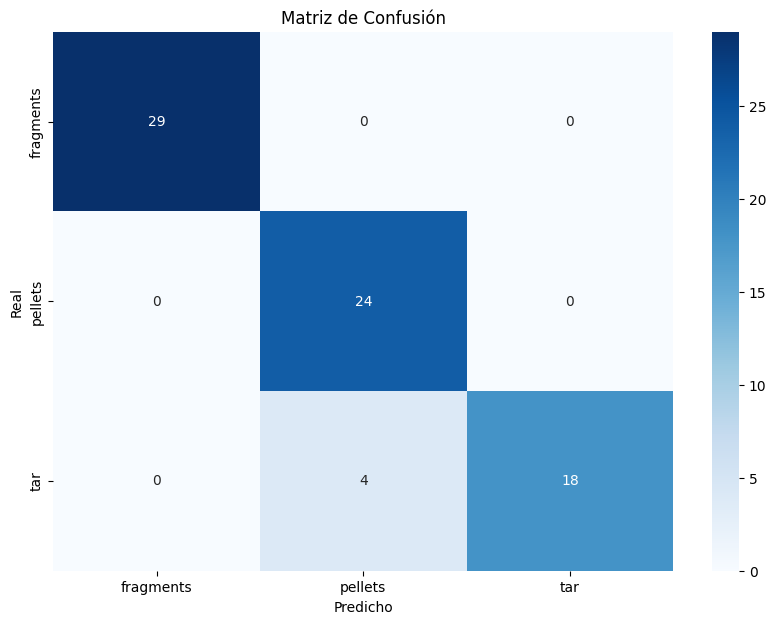

              precision    recall  f1-score   support

   fragments       1.00      1.00      1.00        29
     pellets       0.86      1.00      0.92        24
         tar       1.00      0.82      0.90        22

    accuracy                           0.95        75
   macro avg       0.95      0.94      0.94        75
weighted avg       0.95      0.95      0.95        75



In [3]:



# Cargar imágenes sin redimensionar
images = {
    'fragments': cv2.imread('FRA.png'),
    'pellets': cv2.imread('PEL.png'),
    'tar': cv2.imread('TAR.png')
}

# Función de preprocesamiento
def preprocess_image(image):
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Aplicar desenfoque gaussiano
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Aplicar umbral binario inverso con el método Otsu
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return thresh

# Función de extracción de características con reducción de histogramas
def extract_features(contour, gray_image):
    # Calcular el área y el perímetro del contorno
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    # Calcular la compacidad
    compactness = (perimeter ** 2) / area if area != 0 else 0
    # Obtener el rectángulo delimitador y su relación de aspecto
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h != 0 else 0
    # Ajustar el contorno a una elipse si es posible
    ellipse = cv2.fitEllipse(contour) if len(contour) >= 5 else None
    major_axis = max(ellipse[1]) if ellipse else 0
    minor_axis = min(ellipse[1]) if ellipse else 0
    axis_ratio = major_axis / minor_axis if minor_axis != 0 else 0
    # Calcular la convexidad y solidez
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area != 0 else 0
    
    # Características de textura usando OpenCV con reducción de bins
    mask = np.zeros(gray_image.shape, dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    masked = cv2.bitwise_and(gray_image, gray_image, mask=mask)
    hist = cv2.calcHist([masked], [0], mask, [32], [0, 256])  # Histograma con 32 bins
    hist = cv2.normalize(hist, hist).flatten()  # Normalizar el histograma
    
    return [area, perimeter, compactness, aspect_ratio, axis_ratio, solidity] + hist.tolist()

# Funciones de aumento de datos utilizando OpenCV
def horizontal_flip(image):
    # Invertir horizontalmente la imagen
    return cv2.flip(image, 1)

def rotate_image(image, angle):
    # Rotar la imagen según el ángulo dado
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def adjust_brightness(image, factor):
    # Ajustar el brillo de la imagen
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:, :, 2] = hsv[:, :, 2] * factor
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255
    hsv = np.array(hsv, dtype=np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def gaussian_blur(image, kernel_size):
    # Aplicar desenfoque gaussiano
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Procesar cada imagen y extraer características en paralelo
def process_image(label, image):
    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Aplicar preprocesamiento
    thresh = preprocess_image(image)
    # Encontrar contornos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    data = []
    labels = []
    # Extraer características de cada contorno
    for contour in contours:
        if cv2.contourArea(contour) > 5:  # Umbral para contornos pequeños
            features = extract_features(contour, gray_image)
            data.append(features)
            labels.append(label)
    return data, labels

# Aumentar las imágenes y procesarlas
augmented_results = []
for label, image in images.items():
    # Aplicar aumentos a cada imagen
    augmented_images = [
        image,
        horizontal_flip(image),
        rotate_image(image, 15),
        rotate_image(image, -15),
        adjust_brightness(image, 1.2),
        adjust_brightness(image, 0.8),
        gaussian_blur(image, 5)
    ]
    for aug_image in augmented_images:
        augmented_results.append(process_image(label, aug_image))

# Unificar los resultados en una sola lista
data = [item for sublist in augmented_results for item in sublist[0]]
labels = [item for sublist in augmented_results for item in sublist[1]]

# Convertir los datos en un DataFrame
columns = ['Area', 'Perimeter', 'Compactness', 'Aspect_Ratio', 'Axis_Ratio', 'Solidity'] + [f'Hist_{i}' for i in range(32)]
df = pd.DataFrame(data, columns=columns)
df['Label'] = labels

# Dividir los datos en entrenamiento y prueba
X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el clasificador RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predecir y evaluar
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Imprimir el informe de clasificación
print(report)
